### Necessary Imports

In [1]:
import os
import sys
import glob
import matplotlib.pyplot as plt

parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)
from data import get_dataloader, dataloader_sampler, visualize_spectrogram

plt.style.use("default")

Loading the data and visualizing samples

In [2]:
speech_dir = os.path.abspath("../data/speech_files")
speech_files = glob.glob(os.path.join(speech_dir, "*.wav"))
train_dataloader, val_dataloader = get_dataloader(speech_dir)

In [3]:
dataloader_sampler(train_dataloader)

Sample 1 - Data shape: torch.Size([16, 1, 128, 256]), Target shape: torch.Size([16, 1, 128, 256])
Sample 2 - Data shape: torch.Size([16, 1, 128, 256]), Target shape: torch.Size([16, 1, 128, 256])
Sample 3 - Data shape: torch.Size([16, 1, 128, 256]), Target shape: torch.Size([16, 1, 128, 256])
Sample 4 - Data shape: torch.Size([16, 1, 128, 256]), Target shape: torch.Size([16, 1, 128, 256])


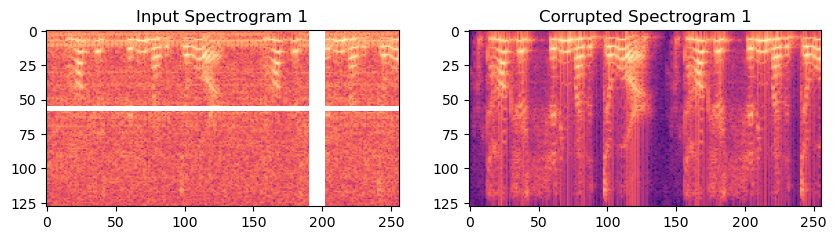

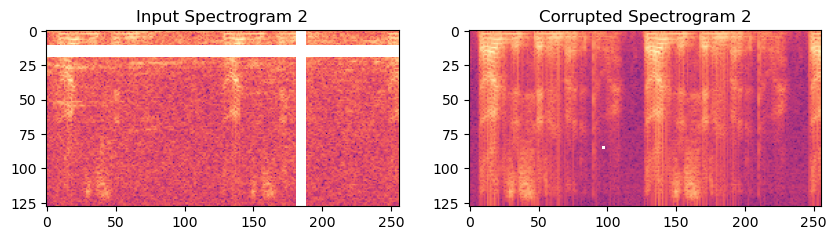

In [4]:
visualize_spectrogram(train_dataloader, num_samples=2)

### Initialize the model

### Training and validation

### Evaluation